# Run for initial setup

In [2]:
# Download the Poker Hand DS
!wget -cq https://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-testing.data
!wget -cq https://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-training-true.data

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

import pandas as pd
import seaborn as sn  # graph confusion matrix
import matplotlib.pyplot as plt
import numpy as np
import time

# Run for helper functions

In [15]:
features = ["S1", "C1", "S2", "C2", "S3", "C3", "S4", "C4", "S5", "C5"]
labels_column = "Hand"

def load_data():
  input_train = "poker-hand-training-true.data"
  input_test = "poker-hand-testing.data"
  names = features + [labels_column]
  df_train = pd.read_csv(input_train, header=None, names=names)
  df_test = pd.read_csv(input_test, header=None, names=names)

  X_train = df_train.drop(columns=labels_column, axis=1)
  y_train = df_train.drop(columns=features, axis=1)
  X_test = df_test.drop(columns=labels_column, axis=1)
  y_test = df_test.drop(columns=features, axis=1)

  return X_train, y_train, X_test, y_test

def transform_input(X):
  """
  Transforms the original 10-dimensions space into a 17-dimensions where the
  dimensions correspond to:
  0  - 12: Rank      0: ace 1: two ... 9: ten 10: jack ... 12: king
  13 - 16: Suite     13: hearts .. 16: lubs
  
  Each dimension keeps the number of times this particular rank or suite
  appeared in the hand.
  """  
  src = X.copy()
  
  dims = 13 + 4  # 13 ranks (ace thru king) + 4 suites (hearts, ...)
  dst = pd.DataFrame(0, index=np.arange(X.shape[0]), columns=np.arange(dims))
  
  suites = (0, 2, 4, 6, 8)
  # Negate the suite's values so that they don't overlap with the ranks
  # e.g. for (1) rank(ace) == suite(hearts)
  src.values[:, suites] *= -1
  
  attributes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -1, -2 , -3, -4]
  for column, attribute in enumerate(attributes):
    tmp = src.copy()
    tmp[tmp != attribute] = 0
    tmp[tmp != 0] = 1
    dst[column] = tmp.sum(axis=1)
    
  return dst

def graph_confusion_matrix(y_truth, y_pred, norm=False):
  """
  Source:
  https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
  """  
  data = confusion_matrix(y_truth, y_pred)
  cm = pd.DataFrame(data, columns=np.unique(y_truth), index=np.unique(y_truth))
  if norm:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cm.index.name, cm.columns.name = 'Ground truth', 'Predicted'
  sn.set_color_codes("muted")
  sn.heatmap(cm, cmap="Blues", annot_kws={"size": 10})

def mlp_report(params, transform=False):

  X_train, y_train, X_test, y_test = load_data()

  if transform:
    X_train = transform_input(X_train)
    X_test = transform_input(X_test)

  # Input is recommended to be scaled
  scaler = StandardScaler()
  
  scaler.fit(X_train)
  X_train_scaled = scaler.transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  # MLP expects a 1d test array
  y_train_plain = y_train.values.ravel()
  clf = MLPClassifier(**params)
  start = time.time()
  clf.fit(X_train_scaled, y_train_plain)
  print("Training duration: ", time.time() - start)

  y_pred = clf.predict(X_test_scaled)
  print(classification_report(y_test, y_pred))

  # Confusion matrix normalized
  graph_confusion_matrix(y_test, y_pred, norm=True)

# Results with original data - 3 hidden layers

Training duration:  23.997986316680908
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    501209
           1       0.99      0.98      0.98    422498
           2       1.00      0.94      0.97     47622
           3       0.99      1.00      0.99     21121
           4       0.96      0.75      0.84      3885
           5       0.99      0.94      0.96      1996
           6       0.97      0.94      0.95      1424
           7       1.00      0.68      0.81       230
           8       0.71      0.83      0.77        12
           9       0.04      0.33      0.07         3

    accuracy                           0.99   1000000
   macro avg       0.86      0.84      0.83   1000000
weighted avg       0.99      0.99      0.98   1000000



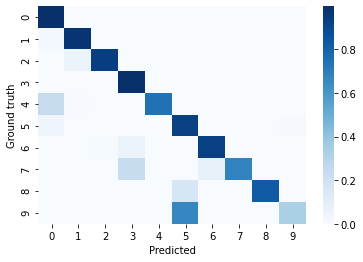

In [18]:
params = {'hidden_layer_sizes': (100, 100, 100 ),
   'alpha': 1e-4,
   'learning_rate_init': 1e-2,
   'tol': 1e-3,
   'max_iter': 100,
}

mlp_report(params, transform=False)

# Results with original data - 2 hidden layers

Training duration:  23.322749376296997
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    501209
           1       0.98      0.99      0.99    422498
           2       0.92      0.91      0.91     47622
           3       0.88      0.88      0.88     21121
           4       0.85      0.51      0.63      3885
           5       0.96      0.88      0.92      1996
           6       0.63      0.53      0.57      1424
           7       0.36      0.24      0.29       230
           8       0.20      0.67      0.30        12
           9       0.00      0.33      0.00         3

    accuracy                           0.98   1000000
   macro avg       0.68      0.69      0.65   1000000
weighted avg       0.98      0.98      0.98   1000000



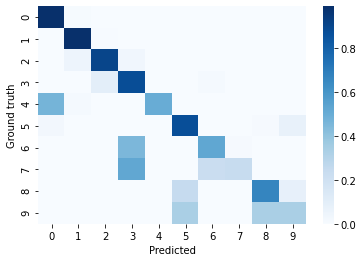

In [19]:
params = {'hidden_layer_sizes': (100, 100, ),
   'alpha': 1e-4,
   'learning_rate_init': 1e-2,
   'tol': 1e-3,
   'max_iter': 100,
}

mlp_report(params, transform=False)

# Results with original data - 1 hidden layer

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training duration:  12.193243503570557
              precision    recall  f1-score   support

           0       0.73      0.93      0.82    501209
           1       0.74      0.59      0.66    422498
           2       0.34      0.07      0.12     47622
           3       0.50      0.29      0.37     21121
           4       0.06      0.01      0.01      3885
           5       0.99      0.92      0.95      1996
           6       0.06      0.00      0.01      1424
           7       0.11      0.03      0.05       230
           8       0.00      0.00      0.00        12
           9       0.01      0.33      0.01         3

    accuracy                           0.73   1000000
   macro avg       0.35      0.32      0.30   1000000
weighted avg       0.71      0.73      0.70   1000000



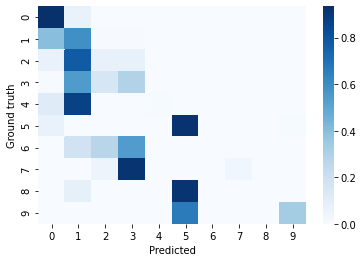

In [24]:
params = {'hidden_layer_sizes': (100, ),
   'alpha': 1e-4,
   'learning_rate_init': 1e-2,
   'tol': 1e-3,
   'max_iter': 100,
}

mlp_report(params, transform=False)

# Results with the transformed data - 2 hidden layers


Training duration:  13.017680168151855
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    501209
           1       1.00      1.00      1.00    422498
           2       1.00      1.00      1.00     47622
           3       0.98      1.00      0.99     21121
           4       1.00      0.99      0.99      3885
           5       1.00      0.96      0.98      1996
           6       0.91      0.70      0.79      1424
           7       0.97      0.44      0.60       230
           8       0.38      0.92      0.54        12
           9       0.60      1.00      0.75         3

    accuracy                           1.00   1000000
   macro avg       0.88      0.90      0.86   1000000
weighted avg       1.00      1.00      1.00   1000000



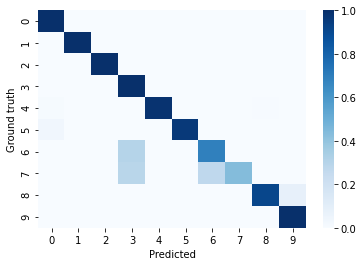

In [21]:
params = {'hidden_layer_sizes': (100, 100, ),
   'alpha': 1e-4,
   'learning_rate_init': 1e-2,
   'tol': 1e-3,
   'max_iter': 100,
}
mlp_report(params, transform=True)

# Results with the transformed data - 1 hidden layer

Training duration:  10.090802431106567
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    501209
           1       1.00      1.00      1.00    422498
           2       0.99      1.00      1.00     47622
           3       0.97      1.00      0.98     21121
           4       1.00      1.00      1.00      3885
           5       1.00      0.95      0.97      1996
           6       0.99      0.50      0.67      1424
           7       0.47      0.07      0.11       230
           8       0.20      0.42      0.27        12
           9       0.09      1.00      0.16         3

    accuracy                           1.00   1000000
   macro avg       0.77      0.79      0.72   1000000
weighted avg       1.00      1.00      1.00   1000000



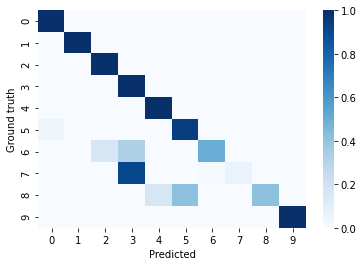

In [23]:
params = {'hidden_layer_sizes': (100, ),
   'alpha': 1e-4,
   'learning_rate_init': 1e-2,
   'tol': 1e-3,
   'max_iter': 100,
}
mlp_report(params, transform=True)